## Consumption Data

In [6]:
import pandas as pd
import numpy as np
np.random.seed(69)
pd.set_option('display.float_format', '{:.2f}'.format)
from datetime import time


# Load data
def load_data():
    data = pd.read_csv('./data/tilos_hourly.csv')
    data['datetime'] = pd.to_datetime(data['datetime'])
    data['value'] = data['value'].astype(np.float32)
    # Rename columns
    data = data.rename(columns={'datetime': 'datetime', 'value': 'consumption'})
    return data

df = load_data()

# Filter data for January, February, and March
df = df[df['datetime'].dt.month.isin([1, 2, 3])]
df.reset_index(drop=True, inplace=True)
df


,datetime,consumption
0,2021-01-01 00:00:00,250.77
1,2021-01-01 01:00:00,231.77
2,2021-01-01 02:00:00,222.87
3,2021-01-01 03:00:00,221.37
4,2021-01-01 04:00:00,220.43
...,...,...
2155,2021-03-31 19:00:00,326.64
2156,2021-03-31 20:00:00,384.50
2157,2021-03-31 21:00:00,381.67
2158,2021-03-31 22:00:00,355.43


## Synthetic Production Data

In [7]:
# Approximate sunrise and sunset times for each month
sunrise_times = {1: 7, 2: 7, 3: 6}   # January, February, March
sunset_times = {1: 17, 2: 18, 3: 19} # January, February, March

# Add a date column
df['date'] = df['datetime'].dt.date

# Calculate daily total consumption
daily_consumption = df.groupby('date')['consumption'].sum().reset_index()

def generate_daily_pv_production(row):
    date = row['date']
    total_consumption = row['consumption']
    month = date.month  # date is a datetime.date object
    sunrise = sunrise_times.get(month, 7)  # Default to 7 AM if month not found
    sunset = sunset_times.get(month, 17)   # Default to 5 PM if month not found

    # Define daylight hours
    daylight_hours = np.arange(sunrise, sunset + 1)
    num_hours = len(daylight_hours)
    
    # Generate a sine wave to simulate solar production
    x = np.linspace(0, np.pi, num_hours)  # Values from 0 to π
    sine_values = np.sin(x)
    
    # Ensure no negative values
    sine_values[sine_values < 0] = 0
    
    # Calculate target PV production (60-70% of daily consumption)
    target_pv_total = total_consumption * np.random.uniform(0.6, 0.7)
    
    # Scale sine wave to match the target PV production
    pv_values = sine_values / sine_values.sum() * target_pv_total
    
    # Create a DataFrame for the PV production
    pv_df = pd.DataFrame({
        'datetime': [pd.Timestamp.combine(date, time(hour=int(h))) for h in daylight_hours],
        'pv_production': pv_values
    })
    return pv_df

# Generate PV production data for all days
pv_dfs = daily_consumption.apply(generate_daily_pv_production, axis=1)
pv_data = pd.concat(pv_dfs.tolist(), ignore_index=True)

# Merge PV production data into the main DataFrame
df = df.merge(pv_data, on='datetime', how='left')

# Fill NaN values (night hours) with 0
df['pv_production'] = df['pv_production'].fillna(0)

df['consumption'] = df['consumption'].round(2)
df['pv_production'] = df['pv_production'].round(2)

# Preview the updated DataFrame
df


,datetime,consumption,date,pv_production
0,2021-01-01 00:00:00,250.77,2021-01-01,0.00
1,2021-01-01 01:00:00,231.77,2021-01-01,0.00
2,2021-01-01 02:00:00,222.87,2021-01-01,0.00
3,2021-01-01 03:00:00,221.37,2021-01-01,0.00
4,2021-01-01 04:00:00,220.43,2021-01-01,0.00
...,...,...,...,...
2155,2021-03-31 19:00:00,326.64,2021-03-31,0.00
2156,2021-03-31 20:00:00,384.50,2021-03-31,0.00
2157,2021-03-31 21:00:00,381.67,2021-03-31,0.00
2158,2021-03-31 22:00:00,355.43,2021-03-31,0.00


In [8]:
import matplotlib.pyplot as plt

def plot_consumption_production(df, days=None, start_date=None):
    """
    Plots consumption and production data.
    
    Parameters:
    df (DataFrame): The DataFrame containing 'datetime', 'consumption', and 'pv_production'.
    days (int, optional): Number of days to plot. If None, plot the whole DataFrame.
    start_date (str or Timestamp, optional): The start date for plotting. If None, use the first date in the DataFrame.
    """
    # Convert 'datetime' to datetime if not already
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Set the start date
    if start_date is None:
        start_date = df['datetime'].min().date()
    else:
        start_date = pd.to_datetime(start_date).date()
    
    # If 'days' is provided, calculate the end date
    if days is not None:
        end_date = start_date + pd.Timedelta(days=days)
        mask = (df['datetime'] >= pd.Timestamp(start_date)) & (df['datetime'] < pd.Timestamp(end_date))
        plot_df = df.loc[mask]
    else:
        plot_df = df.copy()
    
    # Plot the data
    plt.figure(figsize=(14, 7))
    plt.plot(plot_df['datetime'], plot_df['consumption'], label='Consumption (kW/h)')
    plt.plot(plot_df['datetime'], plot_df['pv_production'], label='PV Production (kW/h)')
    plt.xlabel('Time')
    plt.ylabel('Energy (kW/h)')
    plt.title(f'Consumption and PV Production from {start_date} for {days if days else "all"} days')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


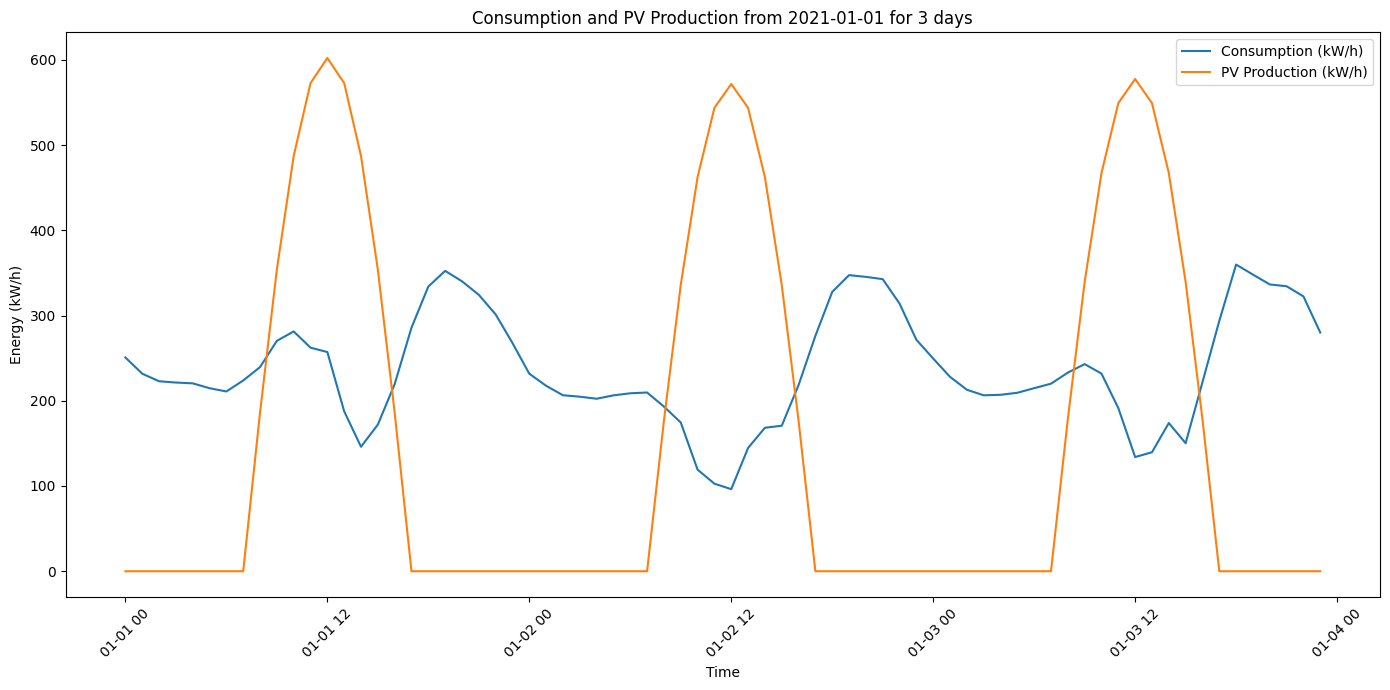

In [9]:
plot_consumption_production(df, days=3)

## EV Data

In [1]:
# Step 4: Load and Synthesize EV Charging Data

import pandas as pd
import numpy as np
import re

# Load EV charging data
ev_data = pd.read_csv('./data/reservations.csv')

# Keep only the necessary columns
ev_data = ev_data[['Consumption (in kWh)', 'Start Time', 'End Time', 'Duration(minutes)']]

# Option 1: Remove the Timezone Information
# Remove the ' (UTC+0200)' from 'Start Time' and 'End Time'
ev_data['Start Time'] = ev_data['Start Time'].str.replace(r'\s*\(UTC[^\)]*\)', '', regex=True)
ev_data['End Time'] = ev_data['End Time'].str.replace(r'\s*\(UTC[^\)]*\)', '', regex=True)

# Parse the datetime
ev_data['Start Time'] = pd.to_datetime(ev_data['Start Time'])
ev_data['End Time'] = pd.to_datetime(ev_data['End Time'])

# Alternatively, use Option 2 if you need to handle the timezones properly.

# Calculate the time difference to shift
min_ev_date = ev_data['Start Time'].min()
target_start_date = pd.Timestamp('2021-01-01')
time_shift = target_start_date - min_ev_date

# Shift the dates
ev_data['Start Time'] = ev_data['Start Time'] + time_shift
ev_data['End Time'] = ev_data['End Time'] + time_shift

# Filter the data to the desired period
ev_data = ev_data[(ev_data['Start Time'] >= '2021-01-01') & (ev_data['Start Time'] <= '2021-03-31')]
ev_data.sort_values(by='Start Time', ascending=True, inplace=True)
ev_data.reset_index(drop=True, inplace=True)


# Preview the data
ev_data


,Consumption (in kWh),Start Time,End Time,Duration(minutes)
0,0.33,2021-01-01 00:00:00,2021-01-01 02:02:00,122.0
1,0.15,2021-01-01 00:02:00,2021-01-01 02:04:00,121.0
2,19.90,2021-01-01 00:12:00,2021-01-01 02:21:00,129.0
3,3.04,2021-01-01 05:12:00,2021-01-01 05:30:00,18.0
4,35.97,2021-01-01 12:00:00,2021-01-01 21:21:00,561.0
...,...,...,...,...
388,2.72,2021-03-29 04:20:00,2021-03-29 04:36:00,16.0
389,8.05,2021-03-29 10:34:00,2021-03-29 21:46:00,672.0
390,11.38,2021-03-29 23:45:00,2021-03-30 01:50:00,125.0
391,6.88,2021-03-30 00:55:00,2021-03-30 02:13:00,78.0


## Aggregation & Preparation

In [2]:
# Step 5: Simulate EV Charging Times

# Define flexibility window in hours
flexibility_window = pd.Timedelta(hours=2)

# Simulate arrival and departure times
ev_data['Arrival Time'] = ev_data['Start Time'] - flexibility_window
ev_data['Departure Time'] = ev_data['End Time'] + flexibility_window

# Ensure times are within the same day
ev_data['Arrival Time'] = ev_data['Arrival Time'].apply(lambda x: max(x, x.normalize()))
ev_data['Departure Time'] = ev_data['Departure Time'].apply(lambda x: min(x, x.normalize() + pd.Timedelta(days=1)))

# Calculate charging duration in hours
ev_data['Charging Duration (hours)'] = ev_data['Duration(minutes)'] / 60

# Preview the data
ev_data[['Start Time', 'End Time', 'Arrival Time', 'Departure Time', 'Charging Duration (hours)']].head()


,Start Time,End Time,Arrival Time,Departure Time,Charging Duration (hours)
0,2021-01-01 00:00:00,2021-01-01 02:02:00,2020-12-31 22:00:00,2021-01-01 04:02:00,2.033333
1,2021-01-01 00:02:00,2021-01-01 02:04:00,2020-12-31 22:02:00,2021-01-01 04:04:00,2.016667
2,2021-01-01 00:12:00,2021-01-01 02:21:00,2020-12-31 22:12:00,2021-01-01 04:21:00,2.150000
3,2021-01-01 05:12:00,2021-01-01 05:30:00,2021-01-01 03:12:00,2021-01-01 07:30:00,0.300000
4,2021-01-01 12:00:00,2021-01-01 21:21:00,2021-01-01 10:00:00,2021-01-01 23:21:00,9.350000


In [4]:
# Function to create an hourly EV load profile for each charging session
def create_ev_load_profile(row):
    start = row['Start Time']
    end = row['End Time']
    consumption = row['Consumption (in kWh)']
    
    # Generate hourly timestamps between start and end
    # Remove the 'closed' parameter
    time_range = pd.date_range(start=start.floor('H'), end=end.ceil('H') - pd.Timedelta(hours=1), freq='H')

    num_hours = len(time_range)
    
    if num_hours == 0:
        # If duration is less than an hour, assign all consumption to the start hour
        time_range = [start.floor('H')]
        num_hours = 1
    
    # Distribute consumption evenly across the hours
    consumption_per_hour = consumption / num_hours
    
    return pd.DataFrame({
        'datetime': time_range,
        'ev_consumption': [consumption_per_hour] * num_hours
    })

# Apply the function to all EV charging sessions
ev_load_profiles = ev_data.apply(create_ev_load_profile, axis=1)

# Concatenate all load profiles
ev_load_data = pd.concat(ev_load_profiles.tolist(), ignore_index=True)

# Aggregate EV consumption by hour
ev_load_data = ev_load_data.groupby('datetime')['ev_consumption'].sum().reset_index()


C:\Users\verxus\AppData\Local\Temp\ipykernel_27764\1007593900.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start.floor('H'), end=end.ceil('H') - pd.Timedelta(hours=1), freq='H')


In [5]:
ev_load_data

,datetime,ev_consumption
0,2021-01-01 00:00:00,6.793333
1,2021-01-01 01:00:00,6.793333
2,2021-01-01 02:00:00,6.793333
3,2021-01-01 05:00:00,3.040000
4,2021-01-01 12:00:00,3.597000
...,...,...
1391,2021-03-30 17:00:00,0.886364
1392,2021-03-30 18:00:00,0.886364
1393,2021-03-30 19:00:00,0.886364
1394,2021-03-30 20:00:00,0.886364


In [8]:
ev_data

,Consumption (in kWh),Start Time,End Time,Duration(minutes),Arrival Time,Departure Time,Charging Duration (hours)
0,0.33,2021-01-01 00:00:00,2021-01-01 02:02:00,122.00,2020-12-31 22:00:00,2021-01-01 04:02:00,2.03
1,0.15,2021-01-01 00:02:00,2021-01-01 02:04:00,121.00,2020-12-31 22:02:00,2021-01-01 04:04:00,2.02
2,19.90,2021-01-01 00:12:00,2021-01-01 02:21:00,129.00,2020-12-31 22:12:00,2021-01-01 04:21:00,2.15
3,3.04,2021-01-01 05:12:00,2021-01-01 05:30:00,18.00,2021-01-01 03:12:00,2021-01-01 07:30:00,0.30
4,35.97,2021-01-01 12:00:00,2021-01-01 21:21:00,561.00,2021-01-01 10:00:00,2021-01-01 23:21:00,9.35
...,...,...,...,...,...,...,...
388,2.72,2021-03-29 04:20:00,2021-03-29 04:36:00,16.00,2021-03-29 02:20:00,2021-03-29 06:36:00,0.27
389,8.05,2021-03-29 10:34:00,2021-03-29 21:46:00,672.00,2021-03-29 08:34:00,2021-03-29 23:46:00,11.20
390,11.38,2021-03-29 23:45:00,2021-03-30 01:50:00,125.00,2021-03-29 21:45:00,2021-03-30 03:50:00,2.08
391,6.88,2021-03-30 00:55:00,2021-03-30 02:13:00,78.00,2021-03-29 22:55:00,2021-03-30 04:13:00,1.30


In [10]:
# Merge the EV load data into the main DataFrame
df = df.merge(ev_load_data, on='datetime', how='left')

# Fill NaN values with 0
df['ev_consumption'] = df['ev_consumption'].fillna(0)

# Round the values
df['ev_consumption'] = df['ev_consumption'].round(2)


In [11]:
df

,datetime,consumption,date,pv_production,ev_consumption
0,2021-01-01 00:00:00,250.77,2021-01-01,0.00,6.79
1,2021-01-01 01:00:00,231.77,2021-01-01,0.00,6.79
2,2021-01-01 02:00:00,222.87,2021-01-01,0.00,6.79
3,2021-01-01 03:00:00,221.37,2021-01-01,0.00,0.00
4,2021-01-01 04:00:00,220.43,2021-01-01,0.00,0.00
...,...,...,...,...,...
2155,2021-03-31 19:00:00,326.64,2021-03-31,0.00,0.00
2156,2021-03-31 20:00:00,384.50,2021-03-31,0.00,0.00
2157,2021-03-31 21:00:00,381.67,2021-03-31,0.00,0.00
2158,2021-03-31 22:00:00,355.43,2021-03-31,0.00,0.00


## Optimization

We will formulate the problem as a linear programming (LP) optimization problem:

Objective:

    Maximize the use of PV production for EV charging.

Variables:

    x_{i,t}: Binary variable indicating whether EV i is charging at time t.

Constraints:

    Charging Duration Constraint: For each EV, the sum over time slots t of x_{i,t} equals the required charging duration in hours.
    ∑t∈Tixi,t=Di
    t∈Ti​∑​xi,t​=Di​

    where:
        TiTi​: Available time slots for EV i between Arrival Time and Departure Time.
        DiDi​: Charging duration required for EV i.

    Time Window Constraint: x_{i,t} can only be non-zero during the available time slots.

    Power Constraint: Total charging power at any time t does not exceed the maximum available PV power.

In [12]:
from pulp import LpProblem, LpVariable, LpInteger, LpMinimize, LpMaximize, lpSum, LpStatus


In [13]:
# Create a time index for the optimization period
start_datetime = df['datetime'].min()
#end_datetime = df['datetime'].max()
end_datetime = start_datetime + pd.Timedelta(weeks=1)
time_index = pd.date_range(start=start_datetime, end=end_datetime, freq='H')

# Create a dictionary of time slots
time_slots = list(time_index)

# Prepare EV sessions with available time slots
ev_sessions = []
for idx, row in ev_data.iterrows():
    ev_id = idx  # Use the index as the EV identifier
    arrival = row['Arrival Time']
    departure = row['Departure Time']
    duration = row['Charging Duration (hours)']
    
    # Get available time slots for this EV
    available_slots = [t for t in time_slots if arrival <= t < departure]
    
    # Store the session information
    ev_sessions.append({
        'ev_id': ev_id,
        'available_slots': available_slots,
        'duration': duration
    })


C:\Users\verxus\AppData\Local\Temp\ipykernel_27764\3687493090.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start=start_datetime, end=end_datetime, freq='H')


In [14]:
ev_sessions

[{'ev_id': 0,
  'available_slots': [Timestamp('2021-01-01 00:00:00'),
   Timestamp('2021-01-01 01:00:00'),
   Timestamp('2021-01-01 02:00:00'),
   Timestamp('2021-01-01 03:00:00'),
   Timestamp('2021-01-01 04:00:00')],
  'duration': 2.033333333333333},
 {'ev_id': 1,
  'available_slots': [Timestamp('2021-01-01 00:00:00'),
   Timestamp('2021-01-01 01:00:00'),
   Timestamp('2021-01-01 02:00:00'),
   Timestamp('2021-01-01 03:00:00'),
   Timestamp('2021-01-01 04:00:00')],
  'duration': 2.0166666666666666},
 {'ev_id': 2,
  'available_slots': [Timestamp('2021-01-01 00:00:00'),
   Timestamp('2021-01-01 01:00:00'),
   Timestamp('2021-01-01 02:00:00'),
   Timestamp('2021-01-01 03:00:00'),
   Timestamp('2021-01-01 04:00:00')],
  'duration': 2.15},
 {'ev_id': 3,
  'available_slots': [Timestamp('2021-01-01 04:00:00'),
   Timestamp('2021-01-01 05:00:00'),
   Timestamp('2021-01-01 06:00:00'),
   Timestamp('2021-01-01 07:00:00')],
  'duration': 0.3},
 {'ev_id': 4,
  'available_slots': [Timestamp('2021

In [15]:
# Initialize the LP problem
prob = LpProblem("EV_Charging_Scheduling", LpMaximize)


In [16]:
# Create decision variables
x = {}

# For each EV session
for session in ev_sessions:
    ev_id = session['ev_id']
    for t in session['available_slots']:
        x[ev_id, t] = LpVariable(f"x_{ev_id}_{t}", cat='Binary')


In [17]:
# Create a dictionary of PV production
pv_dict = df.set_index('datetime')['pv_production'].to_dict()

# Since we have PV production per hour, ensure all time slots are covered
pv_power = {t: pv_dict.get(t, 0) for t in time_slots}

# Assume maximum charging power per EV
max_charging_power = 7  # kW


In [18]:
pv_dict

{Timestamp('2021-01-01 00:00:00'): 0.0,
 Timestamp('2021-01-01 01:00:00'): 0.0,
 Timestamp('2021-01-01 02:00:00'): 0.0,
 Timestamp('2021-01-01 03:00:00'): 0.0,
 Timestamp('2021-01-01 04:00:00'): 0.0,
 Timestamp('2021-01-01 05:00:00'): 0.0,
 Timestamp('2021-01-01 06:00:00'): 0.0,
 Timestamp('2021-01-01 07:00:00'): 0.0,
 Timestamp('2021-01-01 08:00:00'): 186.07,
 Timestamp('2021-01-01 09:00:00'): 353.92,
 Timestamp('2021-01-01 10:00:00'): 487.13,
 Timestamp('2021-01-01 11:00:00'): 572.66,
 Timestamp('2021-01-01 12:00:00'): 602.13,
 Timestamp('2021-01-01 13:00:00'): 572.66,
 Timestamp('2021-01-01 14:00:00'): 487.13,
 Timestamp('2021-01-01 15:00:00'): 353.92,
 Timestamp('2021-01-01 16:00:00'): 186.07,
 Timestamp('2021-01-01 17:00:00'): 0.0,
 Timestamp('2021-01-01 18:00:00'): 0.0,
 Timestamp('2021-01-01 19:00:00'): 0.0,
 Timestamp('2021-01-01 20:00:00'): 0.0,
 Timestamp('2021-01-01 21:00:00'): 0.0,
 Timestamp('2021-01-01 22:00:00'): 0.0,
 Timestamp('2021-01-01 23:00:00'): 0.0,
 Timestamp('2

In [19]:
# Objective: Maximize the use of PV energy for EV charging
prob += lpSum([x[ev_id, t] * pv_power[t] * max_charging_power for (ev_id, t) in x])


In [20]:
for t in time_slots:
    # Sum of charging power at time t
    total_charging_power = lpSum([x[ev_id, t] * max_charging_power for ev_id in range(len(ev_sessions)) if (ev_id, t) in x])
    
    # PV production at time t
    pv_available = pv_power[t]
    
    # Constraint: Total charging power <= PV production
    prob += total_charging_power <= pv_available, f"Power_Constraint_{t}"


In [21]:
# Solve the problem
status = prob.solve()

# Check the status
print("Status:", LpStatus[prob.status])


Status: Optimal


In [22]:
# Create a DataFrame to store the optimized charging schedule
ev_schedule = []

for (ev_id, t), variable in x.items():
    if variable.varValue > 0:
        ev_schedule.append({
            'ev_id': ev_id,
            'datetime': t,
            'charging': variable.varValue * max_charging_power  # kW
        })

ev_schedule_df = pd.DataFrame(ev_schedule)


In [24]:
ev_schedule_df

,ev_id,datetime,charging
0,4,2021-01-01 10:00:00,7.00
1,4,2021-01-01 11:00:00,7.00
2,4,2021-01-01 12:00:00,7.00
3,4,2021-01-01 13:00:00,7.00
4,4,2021-01-01 14:00:00,7.00
5,4,2021-01-01 15:00:00,7.00
6,4,2021-01-01 16:00:00,7.00
7,8,2021-01-02 08:00:00,7.00
8,8,2021-01-02 09:00:00,7.00
9,8,2021-01-02 10:00:00,7.00


In [23]:
# Aggregate the EV charging load per time slot
ev_optimized_load = ev_schedule_df.groupby('datetime')['charging'].sum().reset_index()

# Merge the optimized EV load into the main DataFrame
df = df.merge(ev_optimized_load, on='datetime', how='left')

# Fill NaN values with 0
df['optimized_ev_consumption'] = df['charging'].fillna(0)

# Drop the 'charging' column
df = df.drop(columns=['charging'])

# Round the values
df['optimized_ev_consumption'] = df['optimized_ev_consumption'].round(2)


In [24]:
df

,datetime,consumption,date,pv_production,ev_consumption,optimized_ev_consumption
0,2021-01-01 00:00:00,250.77,2021-01-01,0.00,6.79,0.00
1,2021-01-01 01:00:00,231.77,2021-01-01,0.00,6.79,0.00
2,2021-01-01 02:00:00,222.87,2021-01-01,0.00,6.79,0.00
3,2021-01-01 03:00:00,221.37,2021-01-01,0.00,0.00,0.00
4,2021-01-01 04:00:00,220.43,2021-01-01,0.00,0.00,0.00
...,...,...,...,...,...,...
2155,2021-03-31 19:00:00,326.64,2021-03-31,0.00,0.00,0.00
2156,2021-03-31 20:00:00,384.50,2021-03-31,0.00,0.00,0.00
2157,2021-03-31 21:00:00,381.67,2021-03-31,0.00,0.00,0.00
2158,2021-03-31 22:00:00,355.43,2021-03-31,0.00,0.00,0.00


In [25]:
def plot_consumption_production_ev(df, days=None, start_date=None):
    # Convert 'datetime' to datetime if not already
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Set the start date
    if start_date is None:
        start_date = df['datetime'].min().date()
    else:
        start_date = pd.to_datetime(start_date).date()
    
    # If 'days' is provided, calculate the end date
    if days is not None:
        end_date = start_date + pd.Timedelta(days=days)
        mask = (df['datetime'] >= pd.Timestamp(start_date)) & (df['datetime'] < pd.Timestamp(end_date))
        plot_df = df.loc[mask]
    else:
        plot_df = df.copy()
    
    # Plot the data
    plt.figure(figsize=(14, 7))
    plt.plot(plot_df['datetime'], plot_df['consumption'], label='Consumption (kW/h)')
    plt.plot(plot_df['datetime'], plot_df['pv_production'], label='PV Production (kW/h)')
    plt.plot(plot_df['datetime'], plot_df['ev_consumption'], label='Original EV Consumption (kW/h)', linestyle='--')
    plt.plot(plot_df['datetime'], plot_df['optimized_ev_consumption'], label='Optimized EV Consumption (kW/h)', linestyle='-.')
    plt.xlabel('Time')
    plt.ylabel('Energy (kW/h)')
    plt.title(f'Consumption, PV Production, and EV Consumption from {start_date} for {days if days else "all"} days')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


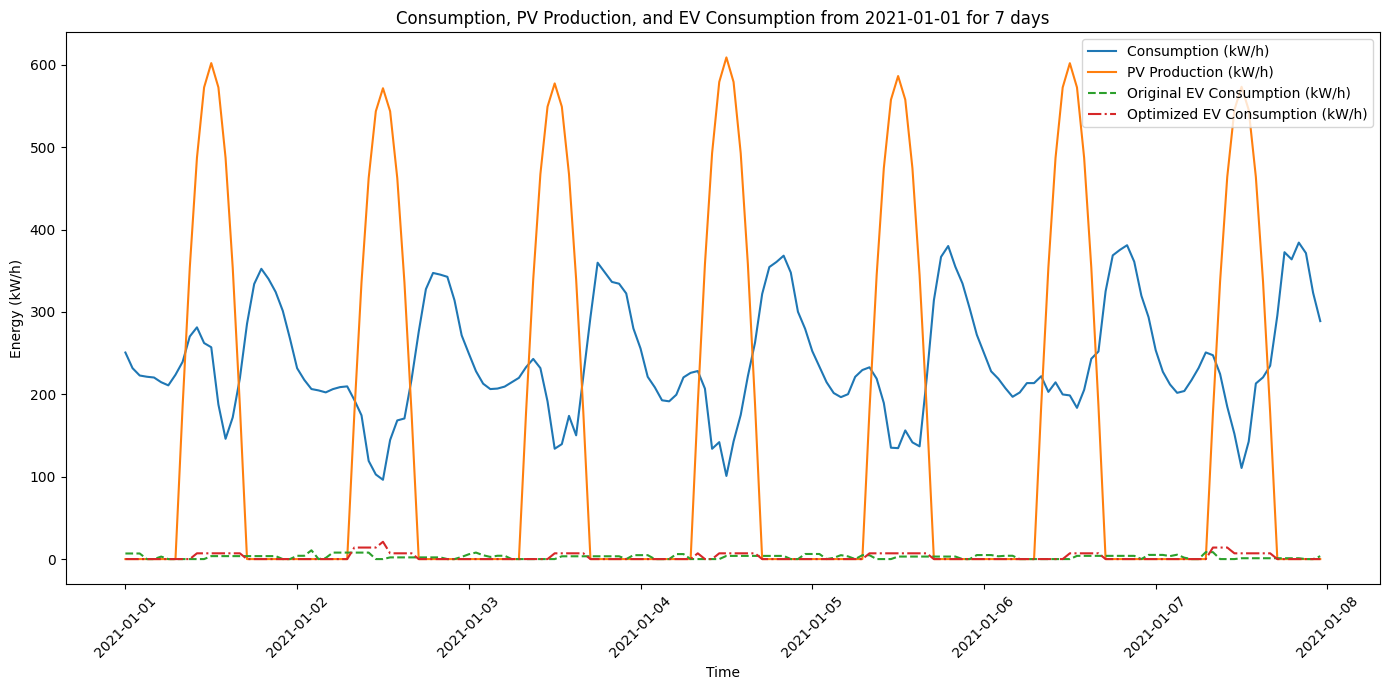

In [26]:
# Plot the first week
plot_consumption_production_ev(df, days=7)


In [29]:
df.head(60)

,datetime,consumption,date,pv_production,ev_consumption,optimized_ev_consumption
0,2021-01-01 00:00:00,250.77,2021-01-01,0.00,6.79,0.00
1,2021-01-01 01:00:00,231.77,2021-01-01,0.00,6.79,0.00
2,2021-01-01 02:00:00,222.87,2021-01-01,0.00,6.79,0.00
3,2021-01-01 03:00:00,221.37,2021-01-01,0.00,0.00,0.00
4,2021-01-01 04:00:00,220.43,2021-01-01,0.00,0.00,0.00
5,2021-01-01 05:00:00,214.73,2021-01-01,0.00,3.04,0.00
6,2021-01-01 06:00:00,210.90,2021-01-01,0.00,0.00,0.00
7,2021-01-01 07:00:00,223.77,2021-01-01,0.00,0.00,0.00
8,2021-01-01 08:00:00,239.50,2021-01-01,186.07,0.00,0.00
9,2021-01-01 09:00:00,270.30,2021-01-01,353.92,0.00,0.00


### more parameters

include the battery of the net metering network